In [495]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
%matplotlib inline
# np.random.seed(46)

In [496]:
#Paramétre de la simulation
TYPE_TIRAGE = "loto" # ou "euromillion"
NB_ANNEES = 10
NB_TIRAGE_PAR_SEMAINE  = 3
PRIX_LOTO = 2.20
NB_TIRAGE_LOTO_SEMAINE = 3


#euromillion 
NB_TIRAGE_EUROMILLION_SEMAINE = 3
PRIX_EUROMILLION = 2.30



 
#Grille du joueur
GRILLE_NUMERO = [2,9,24,33,43]
GRILLE_ETOILE = [5]


#set joueur : 
grille_joueur = {"numero" :set(GRILLE_NUMERO) ,
          "etoile" : set(GRILLE_ETOILE)}


In [497]:
#calcule des gain  et des cout 

if_gain_loto = {
    "0,0":0,
    "1,0":0,
    "1,1": 2.20,
    "0,1": 2.20,
    "2,0": 4.50,
    "2,1": 11.10,
    "3,0": 18.60,
    "3,1": 50,
    "4,0": 335,
    "4,1": 817,
    "5,0": 68000,
    "5,1": 1000000
}
if_gain_euro_million = {
    "0,0":0,
    "1,0":0,
    "1,1":2.30,
    "0,1": 2.30,
    "2,0": 4.50,
    "2,1": 6.20,
    "3,0": 11.20,
    "3,1": 13.40,
    "2,2": 14.10,
    "4,0": 49.80,
    "3,2": 65.60,
    "4,1": 152.2,
    "4,2": 1773.40,
    "5,0": 23809,
    "5,1": 560301,
    "5,2": 10000000
}

def tirage_loto(numero_tirer=5,etoile_tirer=1) ->dict[str : tuple]:
    numero = np.arange(1,50)
    etoile = np.arange(1,10)
    numero = np.random.choice(numero,5,False)
    etoile = np.random.choice(etoile,1,False)    
    tirage = {"numero" : set(numero),
              "etoile" : set(etoile)}
    return tirage

def Calcule_gain_loto(numero_joueur,tirage) -> float:
    nb_numero_gagniant = len(numero_joueur["numero"].intersection((tirage["numero"])))
    nb_etoile_gagniant = len(numero_joueur["etoile"].intersection((tirage["etoile"])))
    select_gain = str(f"{nb_numero_gagniant},{nb_etoile_gagniant}")
    return if_gain_loto[select_gain] - PRIX_LOTO

def Calcule_gain_euromillion(numero_joueur,tirage) -> float:
    nb_numero_gagniant = len(numero_joueur["numero"].intersection((tirage["numero"])))  
    nb_etoile_gagniant = len(numero_joueur["etoile"].intersection((tirage["etoile"])))
    select_gain = str(f"{nb_numero_gagniant},{nb_etoile_gagniant}")
    return if_gain_euro_million[select_gain]

def tirages_loto(numero_joueur,limit_annee = 30,nombre_tirage_semaine=3)-> tuple[pd.DataFrame,pd.DataFrame,pd.DataFrame]:
    data = []
    gain_cumuler = 0
    depense_cumuler = 0
    partie_jouer = 0
    annee = 0
    gain_semaine = 0
    jackpot = 0
    numero_gagniant_repartition = Counter()
    win = True
    while win and annee < limit_annee:
        # print(gain_ans)
        annee += 1
        for semaine in range(0,52):
            gain_semaine +=1
            for jour in range(0,3):
                depense_cumuler += PRIX_LOTO
                partie_jouer +=1
                tirage_n_gagniant = tirage_loto()
                jackpot =  Calcule_gain_loto(numero_joueur,tirage_n_gagniant)   
                gain_cumuler += jackpot
                data.append({
                    "Gain": jackpot,
                    "Gain_cumuler" : round(gain_cumuler,2),
                    "Depense_cumuler": round(depense_cumuler,2),
                    "Annee": annee,
                    "Semaine": gain_semaine,
                    "Numeros_joueur" : numero_joueur["numero"],
                    "Etoile_joueur" : numero_joueur["etoile"],
                    "Numero_gagnant": tirage_n_gagniant["numero"],
                    "Etoile_gagnante": tirage_n_gagniant["etoile"],
                    "Win" : jackpot>=0
                })
                if jackpot >= 100000:
                    print(jackpot)
                    win = False
    print("gain : ",gain_cumuler)
    print("depense : ",depense_cumuler)
    print("annee : ",annee)
    print("semaine : ",gain_semaine)
    print("partie jouer : ",partie_jouer)
    historique_tirage = pd.DataFrame(data).set_index("Annee")
    count_numero_sortie = Counter(chain.from_iterable(historique_tirage.reset_index()["Numero_gagnant"].values))
    count_etoile_sortie = Counter(chain.from_iterable(historique_tirage.reset_index()["Etoile_gagnante"].values))
    numero_gagniant_repartition = pd.DataFrame.from_dict(count_numero_sortie,"index",columns=["frequence"])
    etoile_gagniant_repartition = pd.DataFrame.from_dict(count_etoile_sortie,"index",columns=["frequence"])




    return  historique_tirage,numero_gagniant_repartition, etoile_gagniant_repartition

In [498]:
# Simulation
data_loto,repartition_numero, repartition_etoile =  tirages_loto(grille_joueur,NB_ANNEES,NB_TIRAGE_PAR_SEMAINE)

gain :  -2027.8000000000468
depense :  3431.9999999999154
annee :  10
semaine :  520
partie jouer :  1560


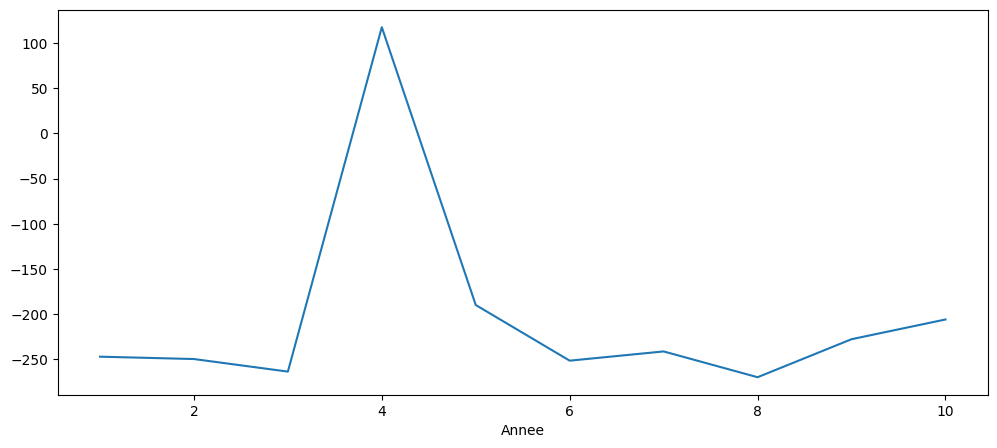

In [499]:
data_loto.groupby("Annee")["Gain"].sum().plot(figsize=[12,5]);

In [500]:
#top 10 des plus gros gros gains
data_loto.nlargest(20,"Gain").nlargest(50,"Gain")

,Gain,Gain_cumuler,Depense_cumuler,Semaine,Numeros_joueur,Etoile_joueur,Numero_gagnant,Etoile_gagnante,Win
Annee,,,,,,,,,
4,332.8,-629.4,1355.2,206,"{33, 2, 9, 43, 24}",{5},"{33, 9, 43, 49, 24}",{7},True
4,16.4,-966.9,1339.8,203,"{33, 2, 9, 43, 24}",{5},"{33, 2, 16, 24, 30}",{3},True
5,16.4,-630.6,1379.4,209,"{33, 2, 9, 43, 24}",{5},"{33, 43, 18, 24, 25}",{2},True
5,16.4,-623.0,1390.4,211,"{33, 2, 9, 43, 24}",{5},"{33, 9, 43, 20, 27}",{1},True
6,16.4,-886.2,1808.4,274,"{33, 2, 9, 43, 24}",{5},"{2, 9, 43, 49, 19}",{1},True
10,16.4,-1827.2,3141.6,476,"{33, 2, 9, 43, 24}",{5},"{2, 35, 9, 20, 24}",{2},True
10,16.4,-1992.7,3381.4,513,"{33, 2, 9, 43, 24}",{5},"{33, 9, 46, 47, 24}",{9},True
1,16.4,-44.9,96.8,15,"{33, 2, 9, 43, 24}",{5},"{33, 9, 43, 18, 23}",{8},True
5,8.9,-723.7,1529.0,232,"{33, 2, 9, 43, 24}",{5},"{33, 2, 36, 44, 21}",{5},True


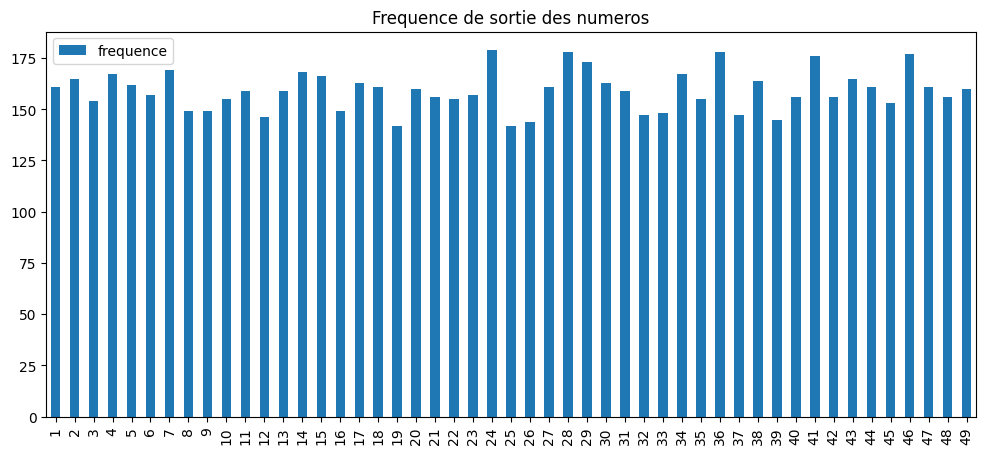

In [501]:
#frequence de sortie des numeros
repartition_numero.sort_index().plot(kind="bar",figsize=[12,5])
plt.title("Frequence de sortie des numeros");


In [507]:
repartition_numero.nsmallest(5,"frequence")
repartition_etoile.nsmallest(1,"frequence")

,frequence
3,148


In [532]:
#recupere les nombres les moins souvent sortie
numero_sortie_moin_souvent = list(repartition_numero.nsmallest(5,"frequence")["frequence"].index)
etoile_sortie_moin_souvent = list(repartition_etoile.nsmallest(1,"frequence")["frequence"].index)
display(numero_sortie_moin_souvent,etoile_sortie_moin_souvent)




[25, 19, 26, 39, 12]

[3]

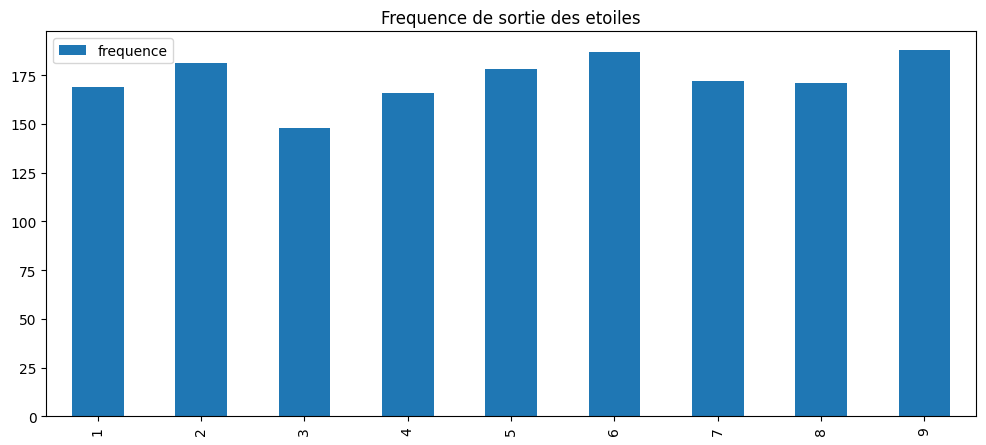

In [506]:
#frequence de sortie des etoiles
repartition_etoile.sort_index().plot(kind="bar",figsize=[12,5])
plt.title("Frequence de sortie des etoiles");

In [504]:
  data_loto["Numero_gagnant"].apply(Counter)

Annee
1      {6: 1, 38: 1, 42: 1, 22: 1, 30: 1}
1       {1: 1, 3: 1, 21: 1, 22: 1, 27: 1}
1      {9: 1, 44: 1, 25: 1, 28: 1, 31: 1}
1     {11: 1, 45: 1, 15: 1, 16: 1, 21: 1}
1     {36: 1, 39: 1, 43: 1, 18: 1, 28: 1}
                     ...                 
10      {33: 1, 4: 1, 37: 1, 5: 1, 28: 1}
10     {4: 1, 39: 1, 41: 1, 14: 1, 21: 1}
10     {36: 1, 5: 1, 17: 1, 25: 1, 28: 1}
10     {40: 1, 9: 1, 19: 1, 26: 1, 29: 1}
10      {5: 1, 7: 1, 20: 1, 26: 1, 28: 1}
Name: Numero_gagnant, Length: 1560, dtype: object